<a href="https://colab.research.google.com/github/eegli/uzh-nlp/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Google Drive folder

In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')

if not os.getcwd().startswith('/content/drive'):
    os.chdir('drive/MyDrive/NLP')


Mounted at /content/drive


# Stance Predictions (all languages)

In [ ]:
%cd xstance/mbert_baseline 

/content/drive/MyDrive/NLP/xstance/mbert_baseline


In [ ]:
! pip install --quiet -r requirements.txt
! pip install --quiet overrides==3.1.0

## German

In [ ]:
! allennlp predict mymodel ../data/test_2022_de.jsonl \
    --include-package allennlp_xstance \
    --predictor xstance_predictor \
    --cuda-device 0 \
    --output-file ../predictions/mypred_2022_de.jsonl

## French

In [ ]:
! allennlp predict mymodel ../data/test_2022_fr.jsonl \
    --include-package allennlp_xstance \
    --predictor xstance_predictor \
    --cuda-device 0 \
    --output-file ../predictions/mypred_2022_fr.jsonl

## Italian

In [ ]:
! allennlp predict mymodel ../data/test_2022_it.jsonl \
    --include-package allennlp_xstance \
    --predictor xstance_predictor \
    --cuda-device 0 \
    --output-file ../predictions/mypred_2022_it.jsonl

## Full Version (DE/FR/IT)

In [ ]:
! allennlp predict mymodel ../data/test_2022_defrit.jsonl \
    --include-package allennlp_xstance \
    --predictor xstance_predictor \
    --cuda-device 0 \
    --output-file ../predictions/mypred_2022_defrit.jsonl

In [ ]:
%cd ../../

/content/drive


# Create DataFrames

In [2]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
from typing import List, Optional

stance_categories = ["against", "neutral", "favor"]

# By default, only the labels "favor" and "against" are assigned.
# The probability for a label ranges from 0 to 1, and values >= 0.5
# are "favor". We introduce a third label "neutral":
# If the probability for a label lies within 0.5 +/- 1 std,
# we assign the neutral label
def get_stance_label(row: pd.Series, std_list: List[float]) -> str:
    # std_list: [question 1, question 2, question 3, question 4]
    std_dev = std_list[row['question_id'] - 1]
    prob = row['stance_prob']
    if prob > 0.5 + std_dev:
        return stance_categories[2]
    elif prob < 0.5 - std_dev:
        return stance_categories[0]
    return stance_categories[1]


def create_language_data():
    lang_data = []
    for lang in ["de", "fr", "it", "defrit"]:
        preds = pd.read_json(f"xstance/predictions/mypred_2022_{lang}.jsonl",
                             lines=True)
        statements = pd.read_json(f"xstance/data/test_2022_{lang}.jsonl",
                                  lines=True)
        # Add id column so we can merge the two dfs
        preds['id'] = np.arange(1, preds.shape[0] + 1)
        merged = preds.merge(statements, on="id")
        merged.set_index("id", inplace=True)
        # Calculate the word and character count per comment
        merged["comment_wcnt"] = merged.apply(
            lambda row: len(row["comment"].split()), axis=1)
        merged["comment_ccnt"] = merged.apply(lambda row: len(row["comment"]),
                                              axis=1)
        # Split and extract the probability lists
        stance_prob = pd.DataFrame(merged.probs.tolist(),
                                   index=merged.index)[0]
        merged.insert(3, 'stance_prob', stance_prob)
        # Rename
        merged.rename(columns={"label": "stance_label"},
                      inplace=True,
                      errors="raise")
        # Make stance_label a categorical value
        merged['stance_label'] = merged['stance_label'].astype(
            CategoricalDtype(categories=stance_categories))
        # Calculate neutral stance label based on std dev
        std_list = merged.groupby('question_id').std()["stance_prob"].tolist()
        merged["stance_label"] = merged.apply(
            lambda r: get_stance_label(r, std_list), axis=1)
        # Cleanup, drop columns
        merged.drop(["logits", "probs"], axis=1, inplace=True)

        lang_data.append(merged)
    return lang_data


data_de, data_fr, data_it, data_all = create_language_data()
data_all

,stance_label,stance_prob,language,question_id,question,comment,comment_wcnt,comment_ccnt
id,,,,,,,,
1,neutral,0.887301,de,1,Wollen Sie die Volksinitiative «Keine Massenti...,Die Schweiz hat eines der weltweit strengsten ...,61,444
1,neutral,0.887301,fr,1,Acceptez-vous l’initiative populaire «Non à l’...,La loi suisse sur la protection des animaux es...,78,525
1,neutral,0.887301,it,1,Volete accettare l’iniziativa popolare «No all...,La Svizzera dispone di una legge sulla protezi...,78,523
2,against,0.052494,de,1,Wollen Sie die Volksinitiative «Keine Massenti...,Die Initiative will den Schutz der Würde von N...,119,941
2,against,0.052494,fr,1,Acceptez-vous l’initiative populaire «Non à l’...,L’initiative veut protéger dans la Constitutio...,151,1096
...,...,...,...,...,...,...,...,...
135,favor,0.836517,de,4,Wollen Sie die Änderung vom 17. Dezember 2021 ...,Mit der Reform wird die Verrechnungssteuer nur...,37,251
135,favor,0.836517,it,4,Volete accettare la modifica del 17 dicembre 2...,L’imposta preventiva è complicata e onerosa. L...,58,429
136,against,0.150326,de,4,Wollen Sie die Änderung vom 17. Dezember 2021 ...,Die Verrechnungssteuer ist kompliziert und auf...,51,420


# Inspect Data Distribution

### Summaries

In [3]:
data_all.describe()

,stance_prob,question_id,comment_wcnt,comment_ccnt
count,407.000000,407.000000,407.000000,407.000000
mean,0.679599,2.498771,66.235872,442.609337
std,0.338662,1.057170,31.144877,191.442842
min,0.001334,1.000000,19.000000,134.000000
25%,0.447312,2.000000,46.000000,316.000000
50%,0.849735,2.000000,60.000000,404.000000
75%,0.948072,3.000000,76.000000,500.000000
max,0.995549,4.000000,223.000000,1319.000000


In [4]:
data_all.groupby(["question_id",
                  "language"]).agg([np.mean, np.std, np.amax, np.amin])


stance_prob                               comment_wcnt  \
                            mean       std      amax      amin         mean   
question_id language                                                          
1           de          0.450530  0.418543  0.995549  0.001334    52.600000   
            fr          0.464805  0.418453  0.995549  0.001334    67.068966   
            it          0.464805  0.418453  0.995549  0.001334    62.379310   
2           de          0.760780  0.284058  0.994656  0.082510    61.871795   
            fr          0.729994  0.305593  0.994656  0.036558    78.868421   
            it          0.736607  0.304360  0.994656  0.036558    72.564103   
3           de          0.823354  0.222031  0.993332  0.136422    66.026316   
            fr          0.823090  0.221832  0.987926  0.136422    79.605263   
            it          0.827353  0.220509  0.993332  0.136422    73.538462   
4           de          0.613489  0.317371  0.981947  0.048829    49.666667   
            fr          0.650665  0.321297  0.993332  0.048829    63.103448   
            it          0.616513  0.322548  0.981947  0.048829    57.379310   

                                          comment_ccnt                         
                            std amax amin         mean         std  amax amin  
question_id language                                                           
1           de        20.378488  119   25   397.766667  151.559635   941  179  
            fr        27.857970  151   26   455.793103  189.299155  1096  198  
            it        26.111593  142   28   444.413793  178.919678  1054  193  
2           de        28.678049  174   26   426.230769  186.703602  1153  206  
            fr        36.033146  223   26   476.236842  203.947984  1319  180  
            it        33.658341  204   35   474.948718  205.421511  1316  252  
3           de        33.734646  174   26   451.973684  220.440896  1153  206  
            fr        35.477088  223   26   478.815789  201.889836  1319  180  
            it        33.033353  204   35   478.794872  202.949460  1316  252  
4           de        21.446539  111   19   382.433333  158.963167   890  162  
            fr        28.674709  171   24   405.551724  180.350767  1065  139  
            it        25.386180  148   20   399.413793  175.845207  1040  134

### Text Stance Distributions (DE, tail and head)

In [31]:
def get_head_or_tail(df: pd.DataFrame,
                     kind: str,
                     n=5,
                     question_id: Optional[int] = None):
    # Use context to preserve original column width
    with pd.option_context('display.max_colwidth', None):
        view = df[["question_id", 'stance_prob', 'comment']]
        if question_id is not None:
            view = view[view['question_id'] == question_id]
        if kind == "tail":
            display(view.nsmallest(n, columns='stance_prob'))
        elif kind == "head":
            display(view.nlargest(n, columns='stance_prob'))


In [38]:
get_head_or_tail(data_de, "head", n=15)

,question_id,stance_prob,comment
id,,,
26,1,0.995549,"Immer mehr Rinder, Schweine und Hühner leben in besonders tierfreundlichen Ställen und können regelmässig nach draussen. Landwirtinnen und Landwirte, die das Tierwohl besonders achten, werden vom Bund dafür zusätzlich unterstützt."
67,2,0.994656,"Viele ältere Arbeitnehmerinnen und Arbeitnehmer möchten die Erwerbstätigkeit schrittweise reduzieren. AHV 21 kommt dem Bedürfnis entgegen, den Übergang vom Erwerbsleben in den Ruhestand flexibler zu gestalten."
106,3,0.993332,"Viele ältere Arbeitnehmerinnen und Arbeitnehmer möchten die Erwerbstätigkeit schrittweise reduzieren. AHV 21 kommt dem Bedürfnis entgegen, den Übergang vom Erwerbsleben in den Ruhestand flexibler zu gestalten."
68,2,0.987926,"Die Stabilisierung der AHV-Finanzen ist dringend. In den letzten 25 Jahren ist keine umfassende Reform der AHV mehr gelungen. Je länger zugewartet wird, desto teurer wird es für künftige Generationen, die Finanzen der AHV wieder ins Gleichgewicht zu bringen und die AHV-Renten zu sichern."
102,3,0.984158,"Die Reform ist ein Kompromiss aus Mehreinnahmen und Einsparungen. Ohne die zusätzlichen Einnahmen aus der Mehrwertsteuer sind die AHV-Renten in wenigen Jahren nicht mehr ausreichend finanziert. Neben zusätzlichen Einnahmen braucht es auch Einsparungen, die durch die Erhöhung des Rentenalters der Frauen möglich sind."
107,3,0.983933,"Die Stabilisierung der AHV-Finanzen ist dringend. In den letzten 25 Jahren ist keine umfassende Reform der AHV mehr gelungen. Je länger zugewartet wird, desto teurer wird es für künftige Generationen, die Finanzen der AHV wieder ins Gleichgewicht zu bringen und die AHV-Renten zu sichern."
78,3,0.983725,"Mit der Reform AHV 21 wird für Mann und Frau ein einheitliches AHV-Alter von 65 Jahren eingeführt. Dieses bildet die Bezugsgrösse für die flexible Pensionierung und wird deshalb neu als Referenzalter bezeichnet: Wer mit 65 die Rente bezieht, erhält diese ohne Abzüge oder Zuschläge ausbezahlt. Das neue Referenzalter 65 gilt auch für die berufliche Vorsorge (Pensionskasse)."
83,3,0.982244,"Wer sich heute frühzeitig pensionieren lässt, kann die AHV-Rente nur entweder ein Jahr oder zwei Jahre im Voraus beziehen. Zudem muss immer die ganze Rente bezogen werden. Mit AHV 21 lässt sich die Pensionierung in Zukunft flexibler gestalten. Die Rente kann im Alter zwischen 63 und 70 Jahren ab jedem beliebigen Monat bezogen werden3. Neu ist es auch möglich, nur einen Teil der Rente zu beziehen. So wird ein schrittweiser Übergang vom Erwerbsleben in den Ruhestand einfacher. Wie das neue Rentenalter 65 wird auch die Flexibilisierung mit Teilrenten gleichzeitig in der beruflichen Vorsorge verankert."
8,1,0.982095,"Je nach Tiergattung gibt es Unterschiede: 2020 hatten 85 Prozent der Rinder, 51 Prozent der Schweine und 44 Prozent des Nutzgeflügels regelmässig Auslauf. 60 Prozent der Rinder, 68 Prozent der Schweine und 94 Prozent des Nutzgeflügels lebten in einem besonders tierfreundlichen Stall. Die Anteile werden nicht pro Tier, sondern pro Grossvieheinheit berechnet."


In [37]:
get_head_or_tail(data_de, "tail", n=15)

,question_id,stance_prob,comment
id,,,
13,1,0.001334,"Die Initiative hätte grosse Auswirkungen auf die landwirtschaftlichen Betriebe. Rund 3300 Betriebe müssten den Tierbestand reduzieren oder die Betriebsflächen vergrössern. Die Kosten der Tierhaltung würden steigen; viele Betriebe müssten grosse Investitionen tätigen. Berechnungen, die vom Bund in Auftrag gegeben wurden, gehen von jährlichen Mehrkosten von insgesamt 0,4 bis 1,1 Milliarden Franken aus."
14,1,0.001715,"Die Initiative hätte auch Auswirkungen auf die Konsumentinnen und Konsumenten. Lebensmittel wie Fleisch, Eier, Milch oder Käse wären nur noch aus Tierhaltungen mit Bio-Standard erhältlich, ebenso Lebensmittel mit Zutaten tierischer Herkunft. Dadurch wäre die Wahlfreiheit eingeschränkt. Lebensmittel tierischer Herkunft wie auch solche mit Zutaten tierischer Herkunft dürften wegen der höheren Anforderungen teurer werden."
3,1,0.002712,Bundesrat und Parlament lehnen die Initiative ab. Nutztiere sind schon sehr gut geschützt. Immer mehr Tiere werden besonders tierfreundlich gehalten. Ein Importverbot für Produkte ohne Bio-Standard in der Tierhaltung wäre nur mit sehr grossem Aufwand durchzusetzen. Viele Lebensmittel würden teurer.
15,1,0.003011,"Die Initiative könnte zu einer Reduktion der Tierbestände und zu mehr Importen tierischer Herkunft führen. Dies würde die Ammoniak-Emissionen in der Schweiz, aber nicht weltweit reduzieren. Ammoniak ist ein Luftschadstoff, der aus den Exkrementen von Tieren in die Atmosphäre gelangt und sensible Ökosysteme schädigt. Ebenfalls reduziert würden in der Schweiz die Emissionen der Klimagase Methan und Lachgas. Um die Produktion aufrechtzuerhalten, müssten die Betriebe neue Ställe bauen; das würde mehr landwirtschaftliche Nutzfläche verbrauchen."
25,1,0.004828,"Tierhaltung, die das Tierwohl verletzt, ist in der Schweiz verboten. Bundesrat und Parlament halten die Initiative deshalb für unnötig. Würde und Wohlergehen jedes einzelnen Tieres sind gesetzlich bereits geschützt, unabhängig davon, wie viele Tiere zusammen gehalten werden. Entscheidend ist das Wohlergehen jedes einzelnen Tieres und nicht die Anzahl Tiere pro Betrieb."
24,1,0.005058,"Das Tierwohl ist dem Bundesrat und dem Parlament wichtig. Würde und Wohlergehen der Tiere sind in der Schweiz gesetzlich geschützt und immer mehr Nutztiere werden besonders tierfreundlich gehalten. Mit der generellen Verpflichtung zu Bio-Standards in der Tierhaltung geht die Initiative zu weit. Sie würde viele Lebensmittel erheblich verteuern. Ein Importverbot für tierische Produkte, die den geforderten Standard nicht erfüllen, wäre nur mit sehr grossem Aufwand durchzusetzen. Bundesrat und Parlament empfehlen, die Vorlage insbesondere aus folgenden Gründen abzulehnen:"
29,1,0.009177,"Die höheren Standards für importierte Lebensmittel umzusetzen, wäre äusserst schwierig und teuer, insbesondere bei Lebensmitteln mit Zutaten tierischer Herkunft wie Eierteigwaren, Milchschokolade oder Backwaren. In den Herkunftsländern müssten neue Kontrollsysteme aufgebaut werden."
27,1,0.010281,"Die Preise für Lebensmittel wie Fleisch, Milch, Käse oder Eier würden wegen der höheren Anforderungen in der Tierhaltung steigen. Dasselbe gilt für Lebensmittel mit Zutaten tierischer Herkunft. Dies würde insbesondere Konsumentinnen und Konsumenten mit geringem Einkommen treffen. Wegen der höheren Preise in der Schweiz würde wahrscheinlich vermehrt im Ausland eingekauft; der Einkaufstourismus nähme zu. Auch die Betriebe, die in der Schweiz tierische Produkte verarbeiten, müssten dafür höhere Preise bezahlen."
28,1,0.026854,"Die Konsumentinnen und Konsumenten wären in ihrer Wahlfreiheit stark eingeschränkt, da nur noch Produkte tierischer Herkunft erhältlich wären, die bei der Tierhaltung den Bio-Standard erfüllen. Gewisse Produkte könnten ganz aus dem Regal verschwinden."


# Sentiment Analysis (de)

In [34]:
! pip install --quiet transformers

     |████████████████████████████████| 5.3 MB 4.3 MB/s 
     |████████████████████████████████| 163 kB 59.2 MB/s 
     |████████████████████████████████| 7.6 MB 49.5 MB/s 


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model = "oliverguhr/german-sentiment-bert"

tokenizer = AutoTokenizer.from_pretrained(model)

model = AutoModelForSequenceClassification.from_pretrained(model)

categories = ['negative', 'neutral', 'positive']


# Apply a sentiment label
def label(input: str):
    inputs = tokenizer(input, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits
        class_id = logits.argmax().item()
        return model.config.id2label[class_id]


# Make this column categorical - it has the
# known categories "negative", "neutral" and "positive"
sentiment_list = data_de.apply(lambda row: label(row['comment']), axis=1)
data_de['sentiment_label'] = pd.Categorical(sentiment_list,
                                            categories=categories)


In [40]:
data_de

,stance_label,stance_prob,language,question_id,question,comment,comment_wcnt,comment_ccnt,sentiment_label
id,,,,,,,,,
1,neutral,0.887301,de,1,Wollen Sie die Volksinitiative «Keine Massenti...,Die Schweiz hat eines der weltweit strengsten ...,61,444,neutral
2,against,0.052494,de,1,Wollen Sie die Volksinitiative «Keine Massenti...,Die Initiative will den Schutz der Würde von N...,119,941,neutral
3,against,0.002712,de,1,Wollen Sie die Volksinitiative «Keine Massenti...,Bundesrat und Parlament lehnen die Initiative ...,40,299,negative
4,neutral,0.665777,de,1,Wollen Sie die Volksinitiative «Keine Massenti...,Laut Komitee wird das Tierschutzgesetz oft als...,40,320,neutral
5,neutral,0.761419,de,1,Wollen Sie die Volksinitiative «Keine Massenti...,Die Schweiz hat eine der weltweit strengsten u...,56,415,neutral
...,...,...,...,...,...,...,...,...,...
133,neutral,0.663951,de,4,Wollen Sie die Änderung vom 17. Dezember 2021 ...,Auch die Umsatzabgabe ist für den Finanzplatz ...,24,180,neutral
134,neutral,0.662876,de,4,Wollen Sie die Änderung vom 17. Dezember 2021 ...,Die OECD-Steuerreform kommt: Rund 140 Staaten ...,40,311,neutral
135,favor,0.836517,de,4,Wollen Sie die Änderung vom 17. Dezember 2021 ...,Mit der Reform wird die Verrechnungssteuer nur...,37,251,neutral


# Results Overview / Visualization

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

In [96]:
# A few constants to use throughout all plots

ISSUE_LABELS_ENG = [
    "Factory Farming", "OASI Reform 1", "OASI Reform 2", "Withholding Tax"
]
PALETTE = sns.color_palette('pastel')
FIG_SIZE = (18, 9)
AXIS_LABEL_FONTSIZE = 17
TICK_FONTSIZE = 17

## Statement Distribution

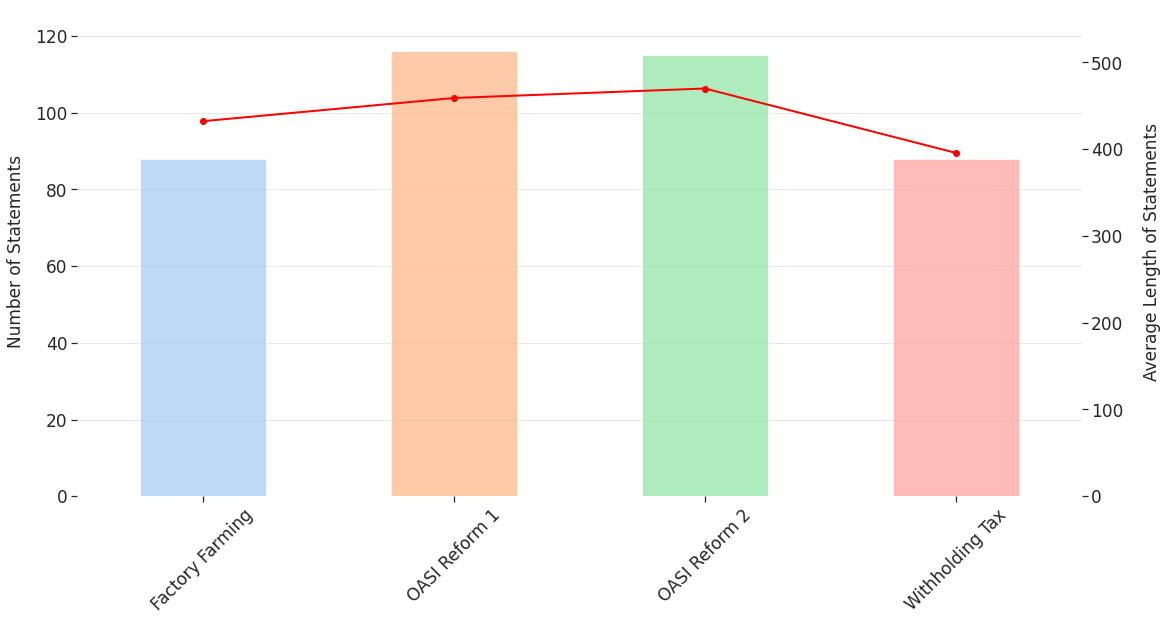

In [97]:
def statement_avg_len(df: pd.DataFrame):
    avg_len = dict()
    for id in df["question_id"]:
        if id not in avg_len.keys():
            sub = df["question_id"] == id
            df_sub = df[sub]
            avg_len[id] = df_sub['comment'].str.len().mean()
    return avg_len


def create_statement_dist_plot(df: pd.DataFrame):
    # copy dataset to distr
    distr = df.copy()

    # distr avg_len
    al = statement_avg_len(distr)
    avg_len = []
    avg_len.append([item for item in al.values()])
    avg_len = avg_len[0]

    # drop redundant columns and rename
    distr.drop(["stance_prob", "language", "question", "comment"],
               axis=1,
               inplace=True)
    distr.rename(columns={"stance_label": "statements"},
                 inplace=True,
                 errors="raise")

    # group by reform (question_id)
    d = distr.groupby("question_id").count()

    # add avg len column to distr
    d['avg_len'] = avg_len

    fig = plt.figure(figsize=FIG_SIZE)
    ax = d['statements'].plot(kind="bar", alpha=0.7, color=PALETTE)

    ax2 = ax.twinx()
    ax2.plot(ax.get_xticks(), d['avg_len'], marker='o', c='red', linewidth=2)

    ax.set_xticklabels(ISSUE_LABELS_ENG, rotation=45, fontsize=TICK_FONTSIZE)
    ax.tick_params(axis='y', labelsize=TICK_FONTSIZE)
    ax2.tick_params(axis='y', labelsize=TICK_FONTSIZE)
    ax.yaxis.grid(True, linestyle='-', color='lightgrey', alpha=0.5)
    ax2.grid(False)
    ax.set_ylim(0, 1.1 * d['statements'].max())
    ax2.set_ylim(0, 1.2 * d['avg_len'].max())
    ax.set_ylabel("Number of Statements",
                  fontsize=AXIS_LABEL_FONTSIZE,
                  labelpad=10)
    ax.set_xlabel(None)
    ax2.set_ylabel("Average Length of Statements",
                   fontsize=AXIS_LABEL_FONTSIZE,
                   labelpad=20)
    ax.set_frame_on(False)
    ax2.set_frame_on(False)


create_statement_dist_plot(data_all)

## Stances

In [98]:
groupby = ["question_id", "stance_label"]
view = groupby + ["comment"]

agg = data_all[view].groupby(groupby).count().unstack()
agg

comment              
stance_label against favor neutral
question_id                       
1                 37    18      33
2                 14    75      27
3                  6    94      15
4                 14    37      37

In [99]:
# Use relative values and normalize to 100% per question
norm = np.round((agg.T / agg.T.sum()).T * 100, 1)
norm

comment              
stance_label against favor neutral
question_id                       
1               42.0  20.5    37.5
2               12.1  64.7    23.3
3                5.2  81.7    13.0
4               15.9  42.0    42.0

<Figure size 432x288 with 0 Axes>

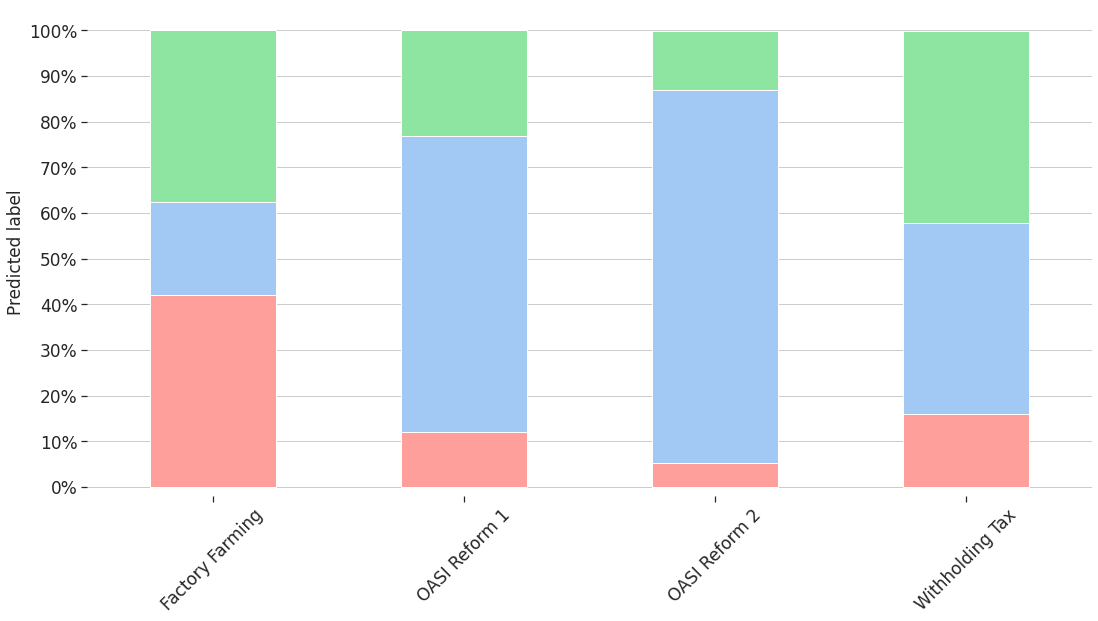

In [100]:
import matplotlib.ticker as mtick


def create_stance_label_dist_plot(df: pd.DataFrame):
    sns.set_theme(style="ticks")
    sns.despine(left=True, bottom=True)

    color = [PALETTE[3], PALETTE[0], PALETTE[2]]

    ax = df.plot(kind='bar', stacked=True, color=color, figsize=FIG_SIZE)
    ax.tick_params(labelsize=TICK_FONTSIZE)
    ax.grid(True, linestyle='-', axis='y')
    ax.set_yticks(np.arange(0, 101, 10))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.set_xticklabels(ISSUE_LABELS_ENG, rotation=45)
    ax.set_ylim(bottom=-2)
    ax.set_ylabel("Predicted label", fontsize=AXIS_LABEL_FONTSIZE)
    ax.set_xlabel(None)
    ax.set_frame_on(False)
    ax.get_legend().remove()


create_stance_label_dist_plot(norm)

In [101]:
def create_stance_prob_dist_figure(data: pd.DataFrame):
    sns.set_theme(style="ticks")

    fig, ax = plt.subplots(figsize=FIG_SIZE)
    ax.tick_params(labelsize=TICK_FONTSIZE)
    ax.yaxis.grid(True, linestyle='-')
    major_ticks = np.arange(0, 1.1, 0.1)
    ax.set_yticks(major_ticks)

    whis = 1.5

    sns.boxplot(x="question_id",
                y="stance_prob",
                data=data,
                medianprops={"color": "red"},
                whis=whis,
                width=.6,
                palette=PALETTE)

    sns.stripplot(x="question_id",
                  y="stance_prob",
                  data=data,
                  size=4,
                  color=".1",
                  linewidth=0)

    ax.set_xticklabels(labels=ISSUE_LABELS_ENG,
                       rotation=45,
                       fontsize=AXIS_LABEL_FONTSIZE)
    ax.set_ylabel("Predicted favor", fontsize=TICK_FONTSIZE)
    ax.set_xlabel(None)

    sns.despine(left=True, bottom=True)


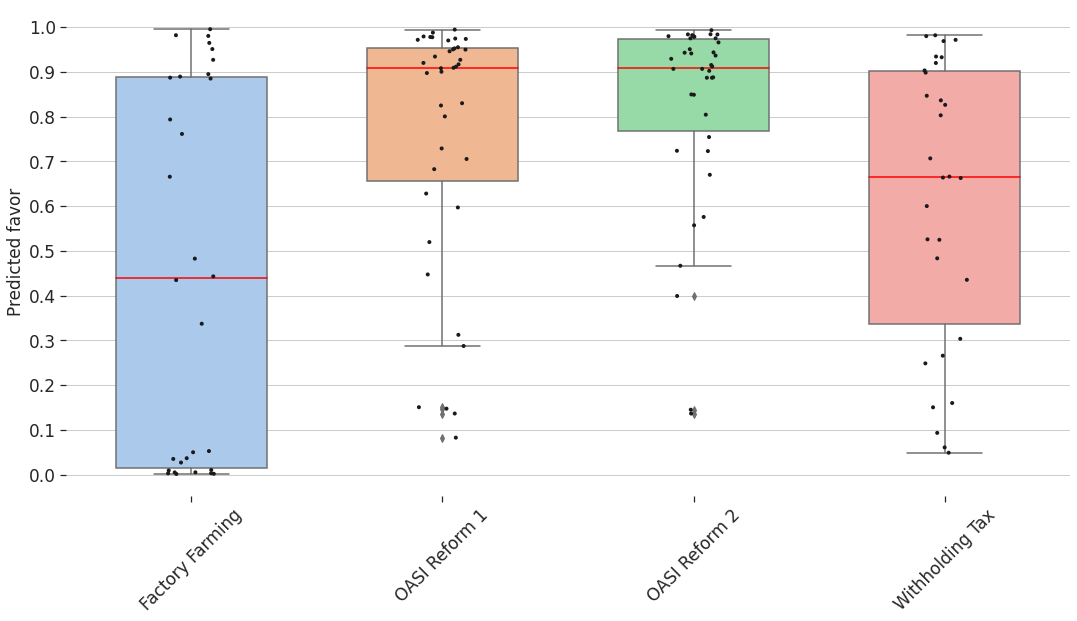

In [102]:
create_stance_prob_dist_figure(data=data_de)

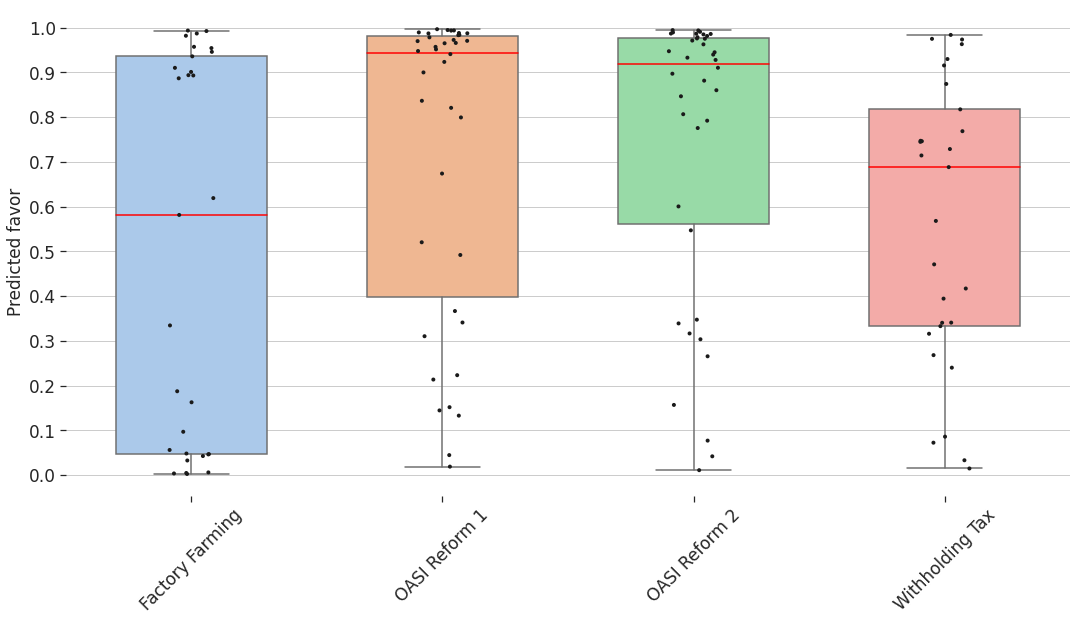

In [103]:
create_stance_prob_dist_figure(data=data_fr)

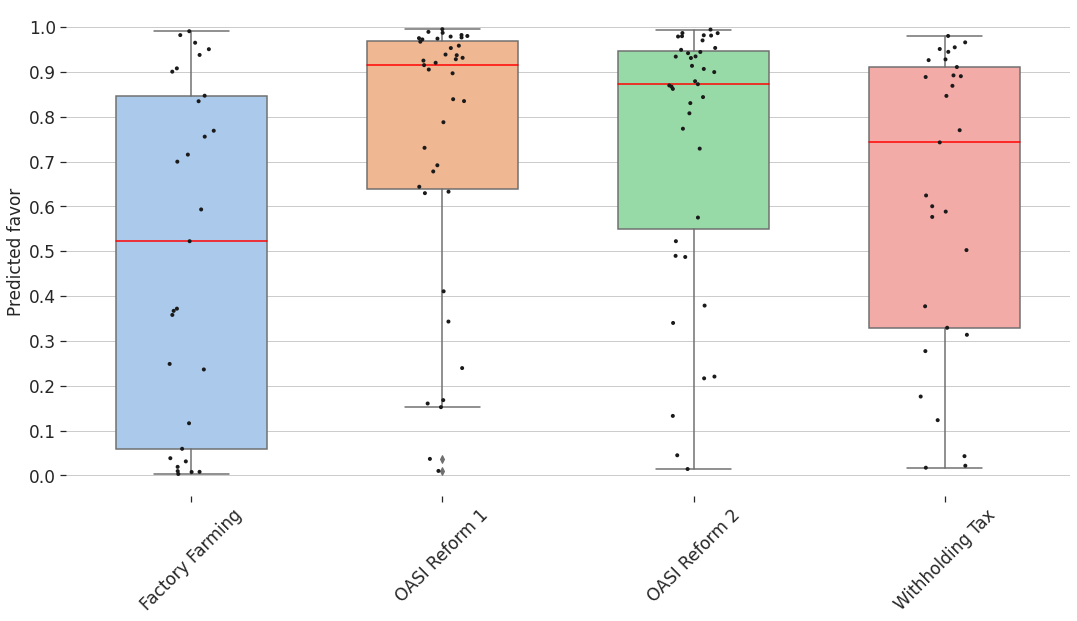

In [104]:
create_stance_prob_dist_figure(data=data_it)

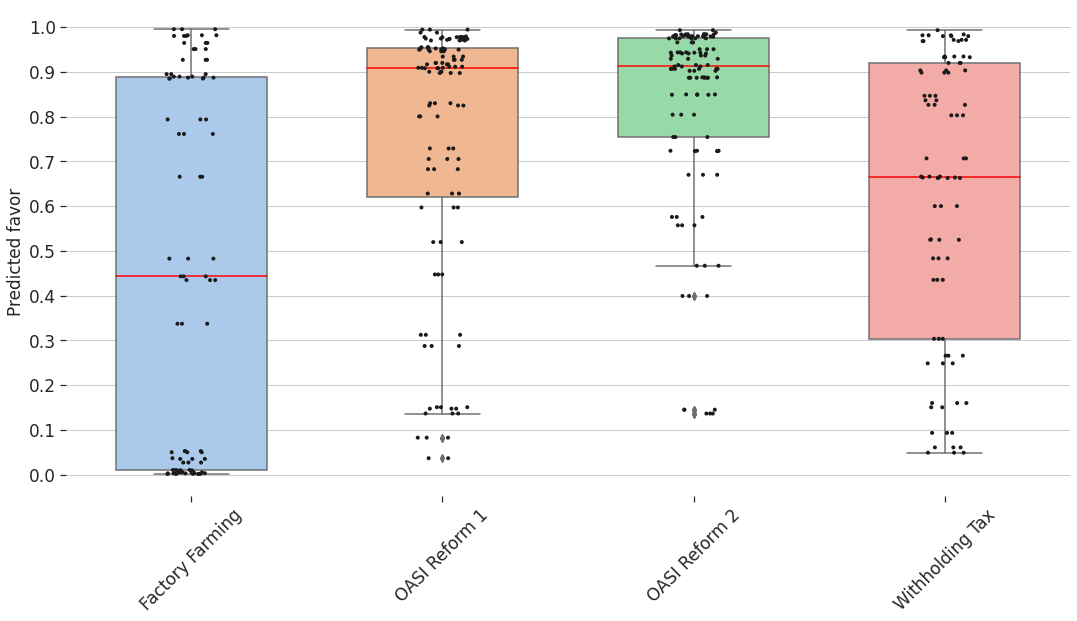

In [105]:
create_stance_prob_dist_figure(data=data_all)

# Experimental

## Sentiment (de)

In [110]:
groupby = ["sentiment_label"]
view = ["sentiment_label", "comment"]

data_de[view].groupby(groupby).count()

,comment
sentiment_label,
negative,11
neutral,126
positive,0


## Sentiment x Stances (de)

In [109]:
groupby = ["stance_label", "sentiment_label"]

data_de.groupby(groupby).size().unstack()

sentiment_label,negative,neutral,positive
stance_label,,,
against,3,21,0
favor,5,70,0
neutral,3,35,0


## Question Answering

In [ ]:
! pip install --quiet transformers PyPDF2

# Patch PIL
import PIL.Image

if not hasattr(PIL.Image, 'Resampling'):  # Pillow<9.0
  PIL.Image.Resampling = PIL.Image

### AutoModel and Tokenizer

In [ ]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline

model_name = "deepset/gelectra-base-germanquad"
model = AutoModelForQuestionAnswering.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

### Create pipeline to generate predictions

In [154]:
nlp = pipeline('question-answering', model=model, tokenizer=tokenizer)


def get_answer(question: str, context: str):
    return nlp({'question': question, 'context': context})

### Questions & Answering

In [166]:
for question in set(data_de['question']):
    comments = data_de[data_de['question'] == question]['comment']
    context = ''.join(comments.tolist())
    print(f"{question}, {get_answer(question, context)}\n")


Wollen Sie die Änderung vom 17. Dezember 2021 des Bundesgesetzes über die Verrechnungssteuer (Verrechnungssteuergesetz, VStG) (Stärkung des Fremdkapitalmarkts) annehmen?, {'score': 7.84906223998405e-05, 'start': 5409, 'end': 5410, 'answer': '.'}

Wollen Sie den Bundesbeschluss vom 17. Dezember 2021 über die Zusatzfinanzierung der AHV durch eine Erhöhung der Mehrwertsteuer annehmen?, {'score': 0.12895166873931885, 'start': 16389, 'end': 16422, 'answer': 'empfehlen Bundesrat und Parlament'}

Wollen Sie die Volksinitiative «Keine Massentierhaltung in der Schweiz (Massentierhaltungsinitiative)» annehmen?, {'score': 0.011970173567533493, 'start': 1385, 'end': 1434, 'answer': 'Bundesrat und Parlament lehnen die Initiative ab.'}

Wollen Sie die Änderung vom 17. Dezember 2021 des Bundesgesetzes über die Alters- und Hinterlassenenversicherung (AHVG) (AHV 21) annehmen?, {'score': 0.012594262138009071, 'start': 201, 'end': 265, 'answer': 'Mit der anderen Vorlage werden die Leistungen der AHV ange